In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

In [3]:
txt_size = 500
epochs = 2
mini_batch = 500

In [5]:
df_train = pd.read_csv("MBTI_train.csv", names=["MBTI", "words"])
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74357 entries, 0 to 74356
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   MBTI    74357 non-null  object
 1   words   74357 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [6]:
df_train.head(5)

,MBTI,words
0,INTP,say process model list like subscriber channel...
1,INFJ,upon much manipulate retail finish like sacrif...
2,INFJ,fit yes certain bff social feel goal go know n...
3,INTJ,complete love within someone ideal joke solvea...
4,ENTJ,public strictly thing person x question person...


In [7]:
df_val_test = df_train.drop(df_train.index).copy()
df_val = df_val_test.sample(frac=0.5, random_state=5).copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9337 entries, 0 to 9336
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   MBTI    0 non-null      object
 1   words   9337 non-null   object
dtypes: object(2)
memory usage: 146.0+ KB


In [9]:
labels_train = df_train['MBTI'].values
data_train = df_train['words'].values

labels_val = df_val['MBTI'].values
data_val = df_val['words'].values

le = LabelEncoder()
en_labels_train = le.fit_transform(labels_train)
en_labels_val = le.transform(labels_val)

Text(0.5, 1.0, 'Count of types')

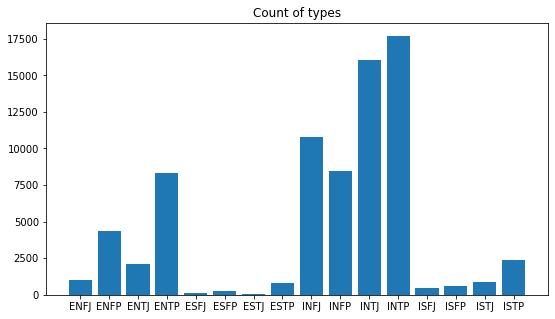

In [10]:
unique_labels, count = np.unique(df_train['MBTI'], return_counts=True)
fig = plt.figure(figsize=(9,5))
plt.bar(unique_labels, count, width=0.8)
plt.title("Count of types")

In [11]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(data_train)

In [12]:
def pad_data(tokenizer, data2pad, maxlen):
    sequence = tokenizer.texts_to_sequences(data2pad)
    paded = pad_sequences(sequence, truncating='post', padding='post', maxlen=maxlen)
    return paded

In [13]:
paded_data_train = pad_data(tokenizer, data_train, txt_size)
paded_data_val = pad_data(tokenizer, data_val, txt_size)

In [14]:
paded_data_train.shape

(74357, 500)

In [15]:
def vectorize_text(text, label): 
    text = tf.expand_dims(text, -1) 
    return vectorize_layer(text), label 
# Vectorize the data. 

max_features = 10000
sequence_length = 500

vectorize_layer = TextVectorization(
    max_tokens=max_features, 
    output_mode="int", 
    output_sequence_length=sequence_length,
)
vectorize_layer.adapt(data_train)
vect_train = vectorize_layer(data_train)
vect_val = vectorize_layer(data_val)

In [16]:
def create_model1(post_size, num_labels):
    model = Sequential([
        layers.Embedding(10000, 32, input_length=post_size),
        layers.Bidirectional(layers.LSTM(40, return_sequences=True)),
        layers.Bidirectional(layers.LSTM(40)),
        layers.Dense(num_labels, activation='softmax')
    ])
    return model

def create_model2(post_size, num_labels):
    inputs = tf.keras.Input(shape=(None,), dtype="int64")
    
    x = layers.Embedding(10000, 128)(inputs)
    x = layers.Dropout(0.5)(x)
    x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
    x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    predictions = layers.Dense(num_labels, activation="sigmoid", name="predictions")(x)
    model = tf.keras.Model(inputs, predictions)
    return model

def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [17]:
model1_token = create_model1(txt_size, len(unique_labels))
model1_token.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model1_token.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 32)           320000    
                                                                 
 bidirectional (Bidirectiona  (None, 500, 80)          23360     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 80)               38720     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 16)                1296      
                                                                 
Total params: 383,376
Trainable params: 383,376
Non-trainable params: 0
_________________________________________________________________


In [18]:
model2_token = create_model2(txt_size, len(unique_labels))
model2_token.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model2_token.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 128)         1280000   
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 conv1d (Conv1D)             (None, None, 128)         114816    
                                                                 
 conv1d_1 (Conv1D)           (None, None, 128)         114816    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                             

In [19]:
model1_vect = create_model1(txt_size, len(unique_labels))
model1_vect.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model1_vect.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 500, 32)           320000    
                                                                 
 bidirectional_2 (Bidirectio  (None, 500, 80)          23360     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 80)               38720     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 16)                1296      
                                                                 
Total params: 383,376
Trainable params: 383,376
Non-trainable params: 0
_________________________________________________________________


In [20]:
model2_vect = create_model2(txt_size, len(unique_labels))
model2_vect.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model2_vect.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_3 (Embedding)     (None, None, 128)         1280000   
                                                                 
 dropout_2 (Dropout)         (None, None, 128)         0         
                                                                 
 conv1d_2 (Conv1D)           (None, None, 128)         114816    
                                                                 
 conv1d_3 (Conv1D)           (None, None, 128)         114816    
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                           

In [22]:
h1_token = model1_token.fit(
    paded_data_train, en_labels_train,
    validation_data = (paded_data_val, en_labels_val),
    epochs = epochs,
    batch_size = mini_batch,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4)
    ]
)

Epoch 1/2
 68/149 [============>.................] - ETA: 1:37:47 - loss: 2.1028 - accuracy: 0.2341

In [ ]:
show_history(h1_token)

In [ ]:
h2_token = model2_token.fit(
    paded_data_train, en_labels_train,
    validation_data = (paded_data_val, en_labels_val),
    epochs = epochs,
    #batch_size = mini_batch,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4)
    ]
)

In [ ]:
show_history(h2_token)

In [ ]:
h1_vect = model1_vect.fit(
    vect_train, en_labels_train,
    validation_data = (vect_val, en_labels_val),
    epochs = 35,
    batch_size = mini_batch,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4)
    ]
)

In [ ]:
show_history(h1_vect)

In [ ]:
h2_vect = model2_vect.fit(
    vect_train, en_labels_train,
    validation_data = (vect_val, en_labels_val),
    epochs = epochs,
    batch_size = mini_batch,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4)
    ]
)

In [ ]:
show_history(h2_vect)

In [ ]:
text_batch, label_batch = data_val.as_numpy_iterator().next()

df_test = pd.read_csv("MBTI_test.csv", names=["words"])
df_test['MBTI'] = np.nan
df_test = df_test[['MBTI', 'words']]
df_test = df_test.astype({'MBTI':'object'})
df_test.info()

inference = model1_token.predict_on_batch(df_test['words'])
df_test['MBTI'] = inference

labels_test = df_test['MBTI'].values
data_test = df_test['words'].values
en_labels_test = le.transform(labels_test)
paded_data_test = pad_data(tokenizer, data_test, txt_size)
vect_test = vectorize_layer(data_test)

In [ ]:
inference.obj.str.strip()
inference.obj.str.upper()

In [ ]:
for i in inference:
    inference[i].obj.str.isupper()
    while True:
        inference[i].obj.str.isupper()
        break
    inference[i].obj.str.isalpha()
    while True:
        inference[i].obj.str.isupper()
        break

In [ ]:
result = pd.DataFrame(inference, columns=['MBTI'])
result.to_csv("Final_result_team14.csv", index=False, header=False)